#### Collocate and cut imagery

In [10]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('/Users/christianboehm/.snap/snap-python')
import snappy
from snappy import ProductIO
from snappy import jpy
HashMap = snappy.jpy.get_type('java.util.HashMap')

PATH = '/Users/christianboehm/projects/sis/data/'

S2_FILE = 's2/S2A_MSIL1C_20230604T172901_N0509_R055_T17XNB_20230604T211530.zip'
S3_FILE = 's3/S3A_OL_1_EFR____20230604T163655_20230604T163955_20230605T174557_0179_099_297_1620_PS1_O_NT_003.SEN3'

TILE_PREFIX = '001'

TILESIZE = 256


In [4]:
s2_raw = ProductIO.readProduct(os.path.join(PATH, S2_FILE))

len(list(s2_raw.getBandNames()))

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.s2tbx.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32617
INFO: org.hsqldb.persist.Logger: dataFileCache open start


72

In [5]:
parameters = HashMap()
parameters.put('sourceBands','B2,B3,B4')

s2_bands = snappy.GPF.createProduct('BandSelect', parameters, s2_raw)

len(list(s2_bands.getBandNames()))


3

100% done.


In [6]:
s3_raw = ProductIO.readProduct(os.path.join(PATH, S3_FILE))

len(list(s3_raw.getBandNames()))


111

In [7]:
parameters = HashMap()
parameters.put('sourceBands','Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance')

s3_bands = snappy.GPF.createProduct('BandSelect', parameters, s3_raw)

len(list(s3_bands.getBandNames()))



100% done.


22

In [8]:
parameters = HashMap()
parameters.put('masterProductName',s2_bands.getName())
# parameters.put('targetProductName','_collocated')
parameters.put('targetProductType','COLLOCATED')
parameters.put('renameMasterComponents','false')
parameters.put('renameSlaveComponents','false')
parameters.put('resamplingType','NEAREST_NEIGHBOUR')
parameters.put('masterComponentPattern','${ORIGINAL_NAME}_M')
parameters.put('slaveComponentPattern','${ORIGINAL_NAME}_S${SLAVE_NUMBER_ID}')

collocated = snappy.GPF.createProduct('Collocate', parameters, [s2_bands, s3_bands])

len(collocated.getBandNames())



100% done.


63

In [9]:
parameters = HashMap()
parameters.put('sourceBands','B2,B3,B4,Oa01_radiance,Oa02_radiance,Oa03_radiance,Oa04_radiance,Oa05_radiance,Oa06_radiance,Oa07_radiance,Oa08_radiance,Oa09_radiance,Oa10_radiance,Oa11_radiance,Oa12_radiance,Oa13_radiance,Oa14_radiance,Oa15_radiance,Oa16_radiance,Oa17_radiance,Oa18_radiance,Oa19_radiance,Oa20_radiance,Oa21_radiance,quality_flags,collocationFlags')

collocated_bands = snappy.GPF.createProduct('BandSelect', parameters, collocated)

len(list(collocated_bands.getBandNames()))


26

100% done.


In [11]:
# Number of tiles in y direction
y_tiles = int(collocated.getSceneRasterHeight() / TILESIZE)
# Starting pixel of each tile (i.e.: width from one tile to the next)
y_step = int(collocated.getSceneRasterHeight() / y_tiles)
# Starting offset to center the tiles on the image, i.e. half the distance between the individual tile gaps
y_offset = int((collocated.getSceneRasterHeight() - ((y_tiles-1)*y_step+(TILESIZE-1))) / 2)

# Number of tiles in x direction
x_tiles = int(collocated.getSceneRasterHeight() / TILESIZE)
# Starting pixel of each tile (i.e.: width from one tile to the next)
x_step = int(collocated.getSceneRasterHeight() / x_tiles)
# Starting offset to center the tiles on the image, i.e. half the distance between the individual tile gaps
x_offset = int((collocated.getSceneRasterHeight() - ((x_tiles-1)*x_step+(TILESIZE-1))) / 2)

# for x in range(x_tiles):
#     print(f'{x_offset+x*x_step}')
#     for y in range(y_tiles):
#         print(f'--{y_offset+y*y_step}')

In [12]:
for x in range(x_tiles):
    for y in range(y_tiles):
        try:
            output_filename = f'tif{TILESIZE}/{TILE_PREFIX}_{x_offset+x*x_step}x{y_offset+y*y_step}.tif'
            if os.path.exists(os.path.join(PATH, output_filename)):
                print(f'File {output_filename} already exists')
                continue

            region = f'{x_offset+x*x_step},{y_offset+y*y_step},{TILESIZE},{TILESIZE}'

            parameters = HashMap()
            parameters.put('referenceBand','B2')
            parameters.put('region',region)
            parameters.put('subSamplingX','1')
            parameters.put('subSamplingY','1')
            parameters.put('fullSwath','false')
            parameters.put('copyMetadata','false')

            cropped = snappy.GPF.createProduct('Subset', parameters, collocated_bands)

            ProductIO.writeProduct(cropped, os.path.join(PATH, output_filename), 'GeoTIFF')
            print(f'product written: {output_filename}')

        except Exception as e:
            print(f'ERROR IN TILE {x_offset+x*x_step}x{y_offset+y*y_step}')
            print(str(e))



100% done.
product written: tif256/001_12x12.tif

100% done.
product written: tif256/001_12x273.tif

100% done.
product written: tif256/001_12x534.tif

100% done.
product written: tif256/001_12x795.tif

100% done.
product written: tif256/001_12x1056.tif

100% done.
product written: tif256/001_12x1317.tif

product written: tif256/001_12x1578.tif
100% done.

100% done.
product written: tif256/001_12x1839.tif

100% done.
product written: tif256/001_12x2100.tif

100% done.
product written: tif256/001_12x2361.tif

product written: tif256/001_12x2622.tif
100% done.

100% done.
product written: tif256/001_12x2883.tif

100% done.
product written: tif256/001_12x3144.tif

100% done.
product written: tif256/001_12x3405.tif

product written: tif256/001_12x3666.tif
100% done.

100% done.
product written: tif256/001_12x3927.tif

100% done.
product written: tif256/001_12x4188.tif

100% done.
product written: tif256/001_12x4449.tif

100% done.
product written: tif256/001_12x4710.tif

product written:

Exception in thread "pool-1120-thread-4" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1120-thread-8" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1120-thread-5" java.lang.UnsupportedOperationException
	at jav

product written: tif256/001_7581x4188.tif

100% done.
ERROR IN TILE 7581x4449
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x4449.tif (No space left on device)

100% done.
ERROR IN TILE 7581x4710
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x4710.tif (No space left on device)

100% done.
ERROR IN TILE 7581x4971
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x4971.tif (No space left on device)

100% done.
ERROR IN TILE 7581x5232
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x5232.tif (No space left on device)

100% done.
ERROR IN TILE 7581x5493
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x5493.tif (No space left on device)

100% done.
ERROR IN TILE 7581x5754
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x5754.tif (No space left on device)

100% done

aFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1121-thread-2" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1121-thread-8" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Threa


100% done.
ERROR IN TILE 7581x6276
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x6276.tif (No space left on device)

100% done.
ERROR IN TILE 7581x6537
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x6537.tif (No space left on device)

100% done.
ERROR IN TILE 7581x6798
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x6798.tif (No space left on device)

100% done.
ERROR IN TILE 7581x7059
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x7059.tif (No space left on device)

100% done.
ERROR IN TILE 7581x7320
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x7320.tif (No space left on device)

100% done.
ERROR IN TILE 7581x7581
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_7581x7581.tif (No space left on device)

100% done.
ERROR IN TILE 7581x7842
java.io.FileNotF

SEVERE: org.esa.snap.jp2.reader.internal.JP2TileOpImage: 
Exception in thread "pool-1122-thread-4" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)



product written: tif256/001_8103x4971.tif
100% done.

100% done.
product written: tif256/001_8103x5232.tif

100% done.
product written: tif256/001_8103x5493.tif

100% done.
product written: tif256/001_8103x5754.tif

100% done.
product written: tif256/001_8103x6015.tif

100% done.
product written: tif256/001_8103x6276.tif

100% done.
product written: tif256/001_8103x6537.tif

product written: tif256/001_8103x6798.tif
100% done.

100% done.
product written: tif256/001_8103x7059.tif

100% done.
product written: tif256/001_8103x7320.tif

100% done.
product written: tif256/001_8103x7581.tif

100% done.
product written: tif256/001_8103x7842.tif

100% done.
product written: tif256/001_8103x8103.tif

100% done.
product written: tif256/001_8103x8364.tif

100% done.
product written: tif256/001_8103x8625.tif

product written: tif256/001_8103x8886.tif
100% done.

100% done.
product written: tif256/001_8103x9147.tif

100% done.
product written: tif256/001_8103x9408.tif

100% done.
product written:

Exception in thread "pool-1190-thread-2" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1190-thread-1" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1190-thread-4" java.lang.UnsupportedOperationException
	at jav


ERROR IN TILE 8625x3144
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x3144.tif (No space left on device)
100% done.
ERROR IN TILE 8625x3405
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x3405.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 8625x3666
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x3666.tif (No space left on device)

100% done.
ERROR IN TILE 8625x3927
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x3927.tif (No space left on device)
ERROR IN TILE 8625x4188
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x4188.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 8625x4449
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8625x4449.tif (No space left on device)

100% done.
ERROR IN TILE 8625x4710
java.io.FileNotF

Exception in thread "pool-1192-thread-2" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1192-thread-8" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1192-thread-7" java.lang.UnsupportedOperationException
	at jav

product written: tif256/001_8886x2622.tif

100% done.
product written: tif256/001_8886x2883.tif


dPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1192-thread-1" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1192-thread-15" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadP


100% done.
ERROR IN TILE 8886x3144
java.io.IOException: No space left on device

100% done.
ERROR IN TILE 8886x3405
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x3405.tif (No space left on device)

100% done.
ERROR IN TILE 8886x3666
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x3666.tif (No space left on device)
ERROR IN TILE 8886x3927
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x3927.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 8886x4188
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x4188.tif (No space left on device)

100% done.
ERROR IN TILE 8886x4449
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x4449.tif (No space left on device)

100% done.
ERROR IN TILE 8886x4710
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x4710.t

dOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1193-thread-11" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1193-thread-16" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.j

product written: tif256/001_8886x4971.tif

100% done.
ERROR IN TILE 8886x5232
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x5232.tif (No space left on device)

100% done.
ERROR IN TILE 8886x5493
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x5493.tif (No space left on device)

100% done.
ERROR IN TILE 8886x5754
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x5754.tif (No space left on device)
ERROR IN TILE 8886x6015
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x6015.tif (No space left on device)

100% done.
ERROR IN TILE 8886x6276
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x6276.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 8886x6537
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x6537.tif (No space left on device)


ava:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1194-thread-3" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1194-thread-5" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java


100% done.
ERROR IN TILE 8886x6798
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x6798.tif (No space left on device)

100% done.
ERROR IN TILE 8886x7059
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x7059.tif (No space left on device)

100% done.
ERROR IN TILE 8886x7320
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x7320.tif (No space left on device)

100% done.
ERROR IN TILE 8886x7581
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x7581.tif (No space left on device)

100% done.
ERROR IN TILE 8886x7842
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x7842.tif (No space left on device)

100% done.
ERROR IN TILE 8886x8103
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_8886x8103.tif (No space left on device)

ERROR IN TILE 8886x8364
java.io.FileNotFoundExcepti

Exception in thread "pool-1195-thread-4" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1195-thread-5" java.lang.UnsupportedOperationException
	at java.util.Collections$UnmodifiableCollection.add(Collections.java:1057)
	at org.esa.snap.core.dataio.ProductIO.lambda$writeRasterDataFully$0(ProductIO.java:586)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Exception in thread "pool-1195-thread-2" java.lang.UnsupportedOperationException
	at jav

product written: tif256/001_9669x8103.tif
ERROR IN TILE 9669x8364
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x8364.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 9669x8625
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x8625.tif (No space left on device)
ERROR IN TILE 9669x8886
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x8886.tif (No space left on device)

100% done.
ERROR IN TILE 9669x9147
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x9147.tif (No space left on device)

100% done.

100% done.
ERROR IN TILE 9669x9408
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x9408.tif (No space left on device)

100% done.
ERROR IN TILE 9669x9669
java.io.FileNotFoundException: /Users/christianboehm/projects/sis/data/tif256/001_9669x9669.tif (No space left on device)
ERROR IN T

INFO: org.hsqldb.persist.Logger: Database closed


In [51]:
# collocated.getSceneRasterHeight()

10980

In [53]:
# parameters = HashMap()
# parameters.put('referenceBand','B2')
# parameters.put('region','20,10000,960,960')
# parameters.put('subSamplingX','1')
# parameters.put('subSamplingY','1')
# parameters.put('fullSwath','false')
# parameters.put('copyMetadata','false')

# try:
#     cropped = snappy.GPF.createProduct('Subset', parameters, collocated_bands)

#     len(cropped.getBandNames())
# except Exception as e:
#     print(f'ERROR IN TILE {x_offset+x*x_step}x{y_offset+y*y_step}')
#     print(str(e))


ERROR IN TILE 20x10000
org.esa.snap.core.gpf.OperatorException: gridHeight >= 2


In [69]:
# list(cropped.getBandNames())

['quality_flags',
 'collocationFlags',
 'B2',
 'B3',
 'B4',
 'Oa01_radiance',
 'Oa02_radiance',
 'Oa03_radiance',
 'Oa04_radiance',
 'Oa05_radiance',
 'Oa06_radiance',
 'Oa07_radiance',
 'Oa08_radiance',
 'Oa09_radiance',
 'Oa10_radiance',
 'Oa11_radiance',
 'Oa12_radiance',
 'Oa13_radiance',
 'Oa14_radiance',
 'Oa15_radiance',
 'Oa16_radiance',
 'Oa17_radiance',
 'Oa18_radiance',
 'Oa19_radiance',
 'Oa20_radiance',
 'Oa21_radiance']

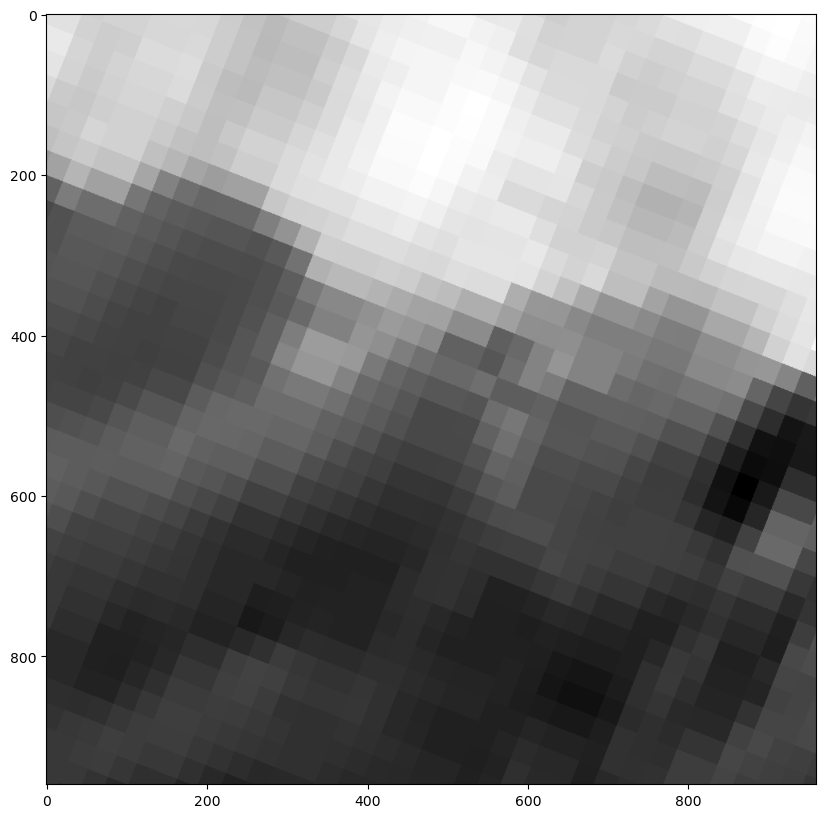

INFO: org.hsqldb.persist.Logger: Database closed


In [77]:

# Using "radiance_3" band as an example
band = cropped.getBand('B2') # Assign Band to a variable
band = cropped.getBand('Oa17_radiance') # Assign Band to a variable
w = cropped.getSceneRasterWidth() # Get Band Width
h = cropped.getSceneRasterHeight() # Get Band Height
# Create an empty array
band_data = np.zeros(w * h, np.float32)
# Populate array with pixel value
band.readPixels(0, 0, w, h, band_data) 
# Reshape
band_data.shape = h, w
# Plot the band  
plt.figure(figsize=(10,10))
plt.imshow(band_data, cmap=plt.cm.binary)
plt.show()

In [78]:
ProductIO.writeProduct(cropped, os.path.join(PATH, 'snappy_test.tif'), 'GeoTIFF')
print("subset product written")

subset product written
